# [CDAF] Atividade 5

## Nome e matrícula
Nome: Bernardo Dutra Lemos  
Matrícula: 2022043949

## Referências
- [1] https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
- [2] https://github.com/metrica-sports/sample-data

## Introdução
Nessa atividade vamos abrir, manipular e fazer algumas análises com os dados de tracking

## Carregando os dados

Acesse [2] e baixe os arquivos do repositório em formato ZIP.

Depois extraia os arquivos pra uma pasta local.

Substitua o caminho da pasta com os jogos de amostra no código abaixo.

In [1]:
DATADIR = 'sample-data-master/data'

## Parte 1

Escolha um dos jogos disponíveis na pasta. Repare que os dados estão anonimizados, então não é possível saber quem são os times e jogadores envolvidos.

In [2]:
game_id = 1

Utilizando os códigos disponíveis em [1] e o tutorial "Tutorial1_GettingStarted.py", carregue os dados de evento e os frames de tracking das duas equipes envolvidas no jogo escolhido.

Em seguida, faça um plot de um evento de gol ou finalização, acrescentando a posição dos jogadores sem bola de ambas as equipes.

Reading team: home
Reading team: away


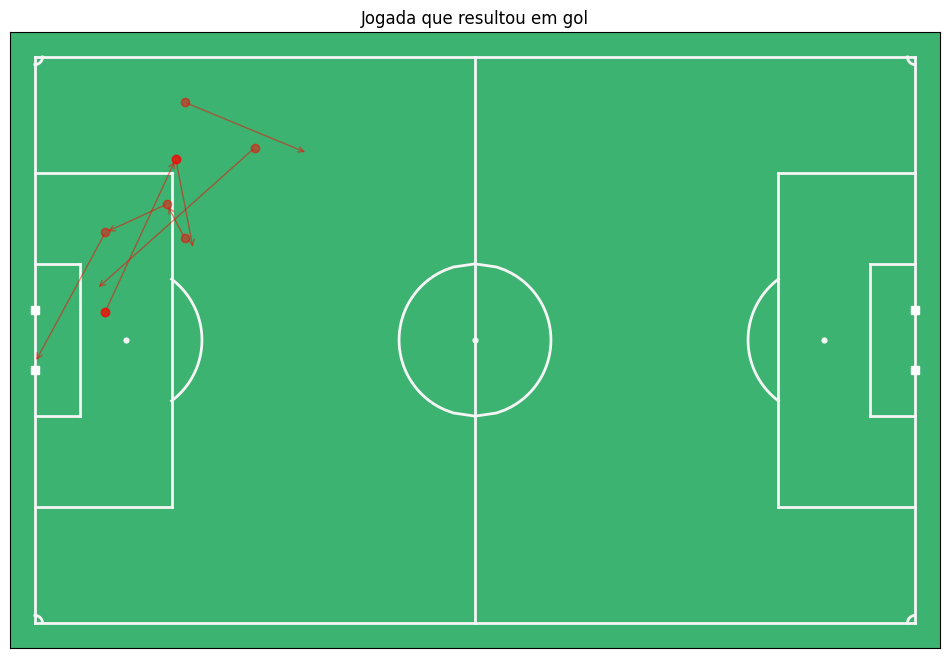

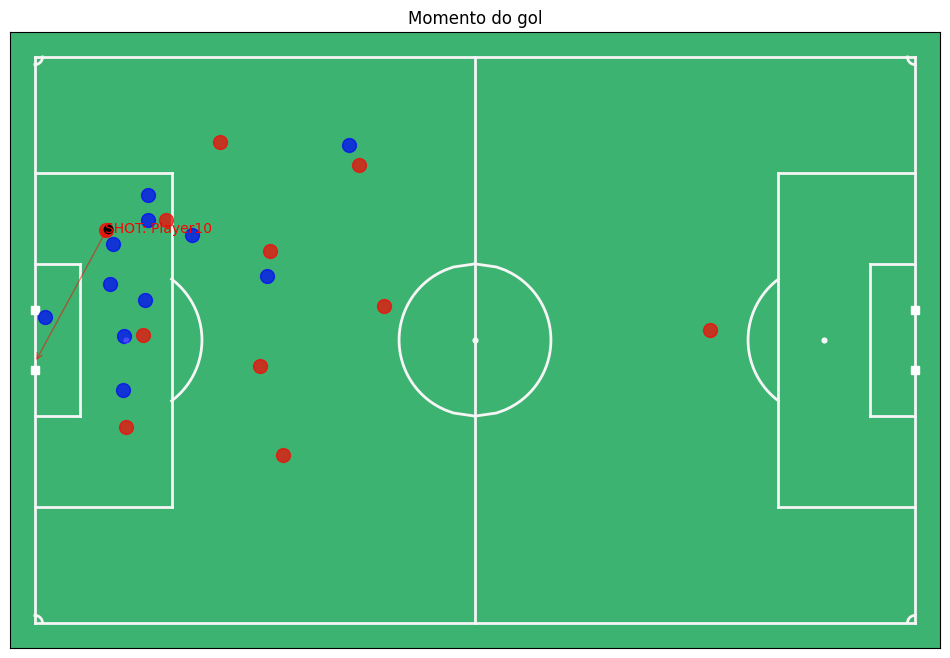

In [3]:
import Metrica_IO as mio
import Metrica_Viz as mviz

# set up initial path to data
# DATADIR = '/PATH/TO/WHERE/YOU/SAVED/THE/SAMPLE/DATA'
# game_id = 2 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# count the number of each event type in the data
# print( events['Type'].value_counts() )

# Bit of housekeeping: unit conversion from metric data units to meters
events = mio.to_metric_coordinates(events)

# Get events by team
home_events = events[events['Team']=='Home']
away_events = events[events['Team']=='Away']

# Frequency of each event type by team
home_events['Type'].value_counts()
away_events['Type'].value_counts()

# Get all shots
shots = events[events['Type']=='SHOT']
home_shots = home_events[home_events.Type=='SHOT']
away_shots = away_events[away_events.Type=='SHOT']

# Look at frequency of each shot Subtype
home_shots['Subtype'].value_counts()
away_shots['Subtype'].value_counts()

# Look at the number of shots taken by each home player
# print( home_shots['From'].value_counts() )

# Get the shots that led to a goal
home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')].copy()
away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL')].copy()

# Add a column event 'Minute' to the data frame
home_goals['Minute'] = home_goals['Start Time [s]']/60.

index = home_goals.index[1]
# plot passing move in run up to goal
fig,ax = mviz.plot_events( events.loc[index-8:index], indicators = ['Marker','Arrow'], annotate=False )
ax.set_title('Jogada que resultou em gol')

#### TRACKING DATA ####

# READING IN TRACKING DATA
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
# PLOT POISTIONS AT GOAL

fig,ax = mviz.plot_events( events.loc[index:index], indicators = ['Marker','Arrow'],annotate=True)
goal_frame = events.loc[index]['Start Frame']
fig,ax = mviz.plot_frame( tracking_home.loc[goal_frame], tracking_away.loc[goal_frame], figax = (fig,ax) )
ax.title.set_text('Momento do gol')

Agora faça um plot descrevendo a trajetória do jogador que finalizou considerando os 1500 frames anteriores ao gol/finalização

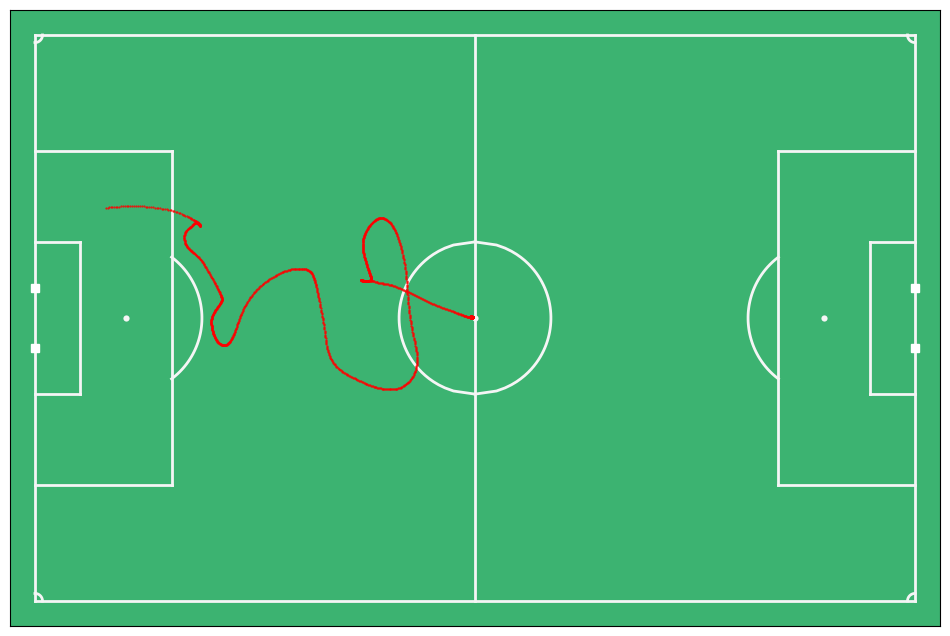

In [4]:
fig,ax = mviz.plot_pitch()
ax.plot( tracking_home['Home_10_x'].iloc[goal_frame-1500:goal_frame], tracking_home['Home_10_y'].iloc[goal_frame-1500:goal_frame], 'r.', markersize=1)

## Parte 2

Utilize o código de "Tutorial2_DelvingDeeper.py" para calcular as velocidades dos jogadores em cada frame. Em seguida faça o plot de um frame qualquer incluindo vetores de velocidade.

Reading team: home
Reading team: away


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

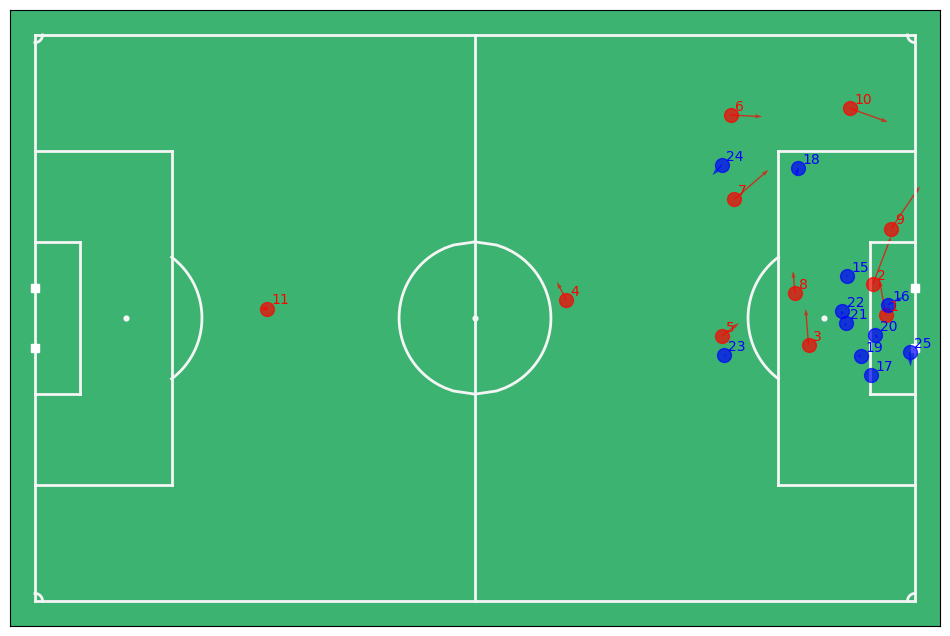

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 13 11:34:26 2020

Script for lesson 5 of "Friends of Tracking" #FoT

Data can be found at: https://github.com/metrica-sports/sample-data

Accompanying video tutorials can be found here: https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w

GitHub repo: https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

@author: Laurie Shaw (@EightyFivePoint)
"""


import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

mviz.plot_frame( tracking_home.loc[2345], tracking_away.loc[2345], include_player_velocities=True, annotate=True)



Crie um resumo físico para os jogadores envolvidos na partida. Plote as distâncias percorridas por cada jogador em cada ritmo (walking, jogging, running, sprinting)

Você consegue dizer a partir desse resumo quais jogadores são os goleiros?

Text(0.5, 1.0, 'Home team')

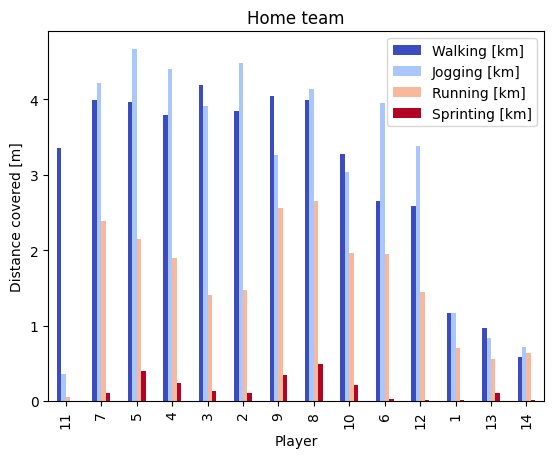

In [6]:
# Create a Physical summary dataframe for home players
home_players = np.unique( [ c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home' ] )
home_summary = pd.DataFrame(index=home_players)

# Calculate minutes played for each player
minutes = []
for player in home_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Home_' + player + '_x' # use player x-position coordinate
    player_minutes = ( tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
home_summary['Minutes Played'] = minutes
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

# Calculate total distance covered for each player
distance = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
home_summary['Distance [km]'] = distance

# now calculate distance covered while: walking, joggings, running, sprinting
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[ tracking_home[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )
    
home_summary['Walking [km]'] = walking
home_summary['Jogging [km]'] = jogging
home_summary['Running [km]'] = running
home_summary['Sprinting [km]'] = sprinting

# make a clustered bar chart of distance covered for each player at each speed
ax = home_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]']].plot.bar(colormap='coolwarm')
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [m]')
ax.set_title('Home team')



- Pelos valores apresentados, acredito que o goleiro do time de casa seja o jogador 11, pois ele anda a maior parte do tempo, mas apresenta alguns momentos de corrida

Text(0.5, 1.0, 'Away team')

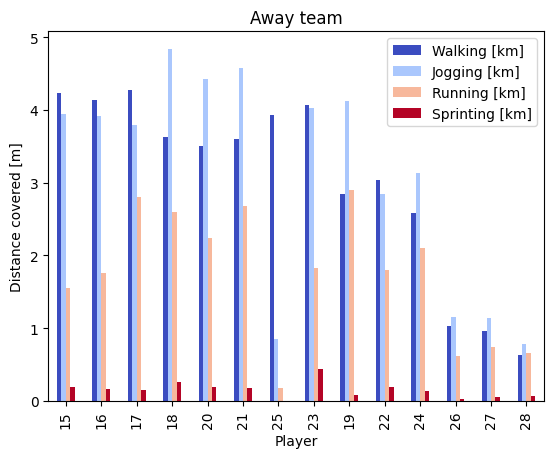

In [7]:
# Create a Physical summary dataframe for away players
away_players = np.unique( [ c.split('_')[1] for c in tracking_away.columns if c[:4] == 'Away' ] )
away_summary = pd.DataFrame(index=away_players)

# Calculate minutes played for each player
minutes = []
for player in away_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Away_' + player + '_x' # use player x-position coordinate
    player_minutes = ( tracking_away[column].last_valid_index() - tracking_away[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
away_summary['Minutes Played'] = minutes
away_summary = away_summary.sort_values(['Minutes Played'], ascending=False)

# Calculate total distance covered for each player
distance = []
for player in away_summary.index:
    column = 'Away_' + player + '_speed'
    player_distance = tracking_away[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
away_summary['Distance [km]'] = distance

# now calculate distance covered while: walking, joggings, running, sprinting
walking = []
jogging = []
running = []
sprinting = []
for player in away_summary.index:
    column = 'Away_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_away.loc[tracking_away[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_away.loc[ (tracking_away[column] >= 2) & (tracking_away[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_away.loc[ (tracking_away[column] >= 4) & (tracking_away[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_away.loc[ tracking_away[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )
    
away_summary['Walking [km]'] = walking
away_summary['Jogging [km]'] = jogging
away_summary['Running [km]'] = running
away_summary['Sprinting [km]'] = sprinting

# make a clustered bar chart of distance covered for each player at each speed
ax = away_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]']].plot.bar(colormap='coolwarm')
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [m]')
ax.set_title('Away team')

- Aparentemente o goleiro do time visitante é o jogador numero 25, pelos mesmos motivos do goleiro do time anterior.

Por fim, escolha um jogador e faça um plot com seus sprints no campo

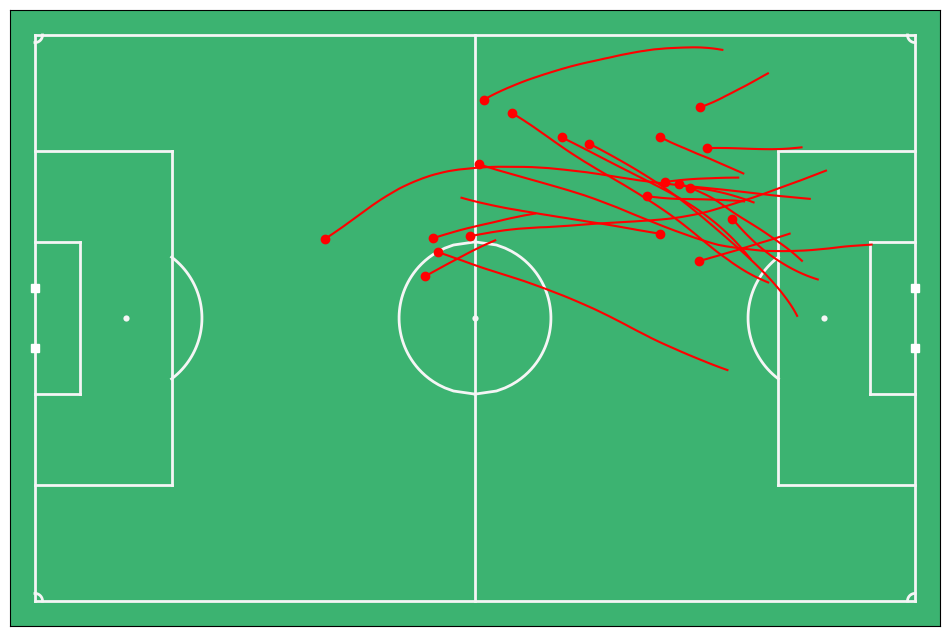

In [9]:
nsprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
    # diff helps us to identify when the window starts
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
home_summary['# sprints'] = nsprints

# Plot the trajectories for each of player 10's sprints
player = '8'
column = 'Home_' + player + '_speed' # spped
column_x = 'Home_' + player + '_x' # x position
column_y = 'Home_' + player + '_y' # y position
# same trick as before to find start and end indices of windows of size 'sprint_window' in which player speed was above the sprint_threshold
player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1 # adding sprint_window/2 because of the way that the convolution is centred
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1
# now plot all the sprints
fig,ax = mviz.plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_home[column_x].iloc[s],tracking_home[column_y].iloc[s],'ro')
    ax.plot(tracking_home[column_x].iloc[s:e+1],tracking_home[column_y].iloc[s:e+1],'r')